In [1]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.optim import SGD, LBFGS
from torch.autograd import grad

## Set up model

In [2]:
def analytic_sol(x):
    return np.exp(-x**2/2)/(1 + x + x**3) + x**2

def forcing(x, net):
    return x**3 + 2*x + x**2 * (1 + 3*x**2)/(1 + x + x**3) \
        - (x + (1 + 3*x**2)/(1 + x + x**3)) * net(x)

def dtrial(x, net, delta):
    # Use a finite difference to approximate the derivative of the trial solution
    return (net(x + delta) - net(x - delta))/(2*delta)

In [3]:
class Net(nn.Module):

    def __init__(self, H, activation='tanh'):
        super(Net, self).__init__()
        self.H = H
        self.z = nn.Linear(1, H)
        self.v = nn.Linear(H, 1, bias=False)
        
        activation = activation.lower()
        if activation == 'relu':       self.sigma = nn.ReLU()
        elif activation == 'sigmoid':  self.sigma = nn.Sigmoid()
        elif activation == 'tanh':     self.sigma = nn.Tanh()
        else:
            raise RuntimeError('specified activation function is not valid')

    def forward(self, x):
        x = x.reshape(-1, 1)
        return torch.add(x * self.v(self.sigma(self.z(x))), torch.tensor([1.]))

## Train the model

In [4]:
# Set parameters
n = 10
H = 100
nepochs = 1000
delta = 1e-6
x = np.linspace(0, 1, n)
x_tens = torch.linspace(0, 1, n, requires_grad=True)

In [5]:
# Main training function
def train(x_tens, nepochs, H, delta, activation='tanh'):
    net = Net(H, activation=activation)
    net.zero_grad()
    criterion = nn.MSELoss()
    optimizer = SGD(net.parameters(), lr=0.01)

    for epoc in range(nepochs):
        for i in range(len(x_tens)):
            batch = x_tens[np.random.randint(0, n)]
            optimizer.zero_grad()
            
            output = net(batch)  # forward
            loss = criterion(dtrial(batch, net, delta), forcing(batch, net))
            loss.backward()  # backward
            optimizer.step()  # optimize
    
    return net

In [6]:
net = train(x_tens, nepochs, H, delta)

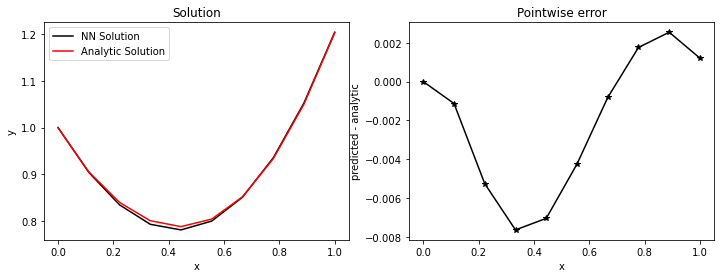

In [7]:
y_pred = net(x_tens).detach().numpy()
ya = analytic_sol(x)

_, (ax1, ax2) = plt.subplots(figsize=(12,4), ncols=2)
ax1.plot(x, y_pred, 'k', x, ya, 'r')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.legend(['NN Solution', 'Analytic Solution'])
ax1.set_title('Solution')

ax2.plot(x, y_pred.flatten() - ya, '-*k')
ax2.set_xlabel('x')
ax2.set_ylabel('predicted - analytic')
ax2.set_title('Pointwise error')
plt.savefig('train.png')
plt.show()

## Predict new solution points

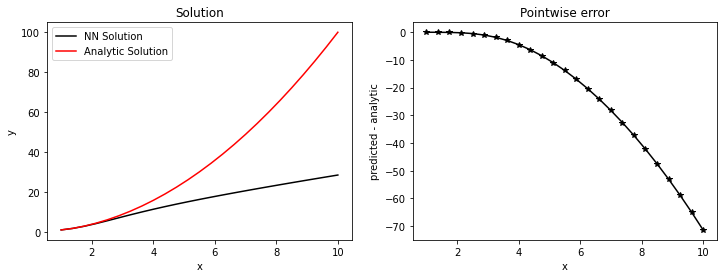

In [8]:
N = 25
x_new = torch.linspace(1, 10, N, requires_grad=True)
xl_new = x_new.detach().numpy()
yp_new = net(x_new).detach().numpy()
ya_new = analytic_sol(x_new.detach().numpy())

_, (ax1, ax2) = plt.subplots(figsize=(12,4), ncols=2)
ax1.plot(xl_new, yp_new, 'k', xl_new, ya_new, 'r')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.legend(['NN Solution', 'Analytic Solution'])
ax1.set_title('Solution')

ax2.plot(xl_new, yp_new.flatten() - ya_new, '-*k')
ax2.set_xlabel('x')
ax2.set_ylabel('predicted - analytic')
ax2.set_title('Pointwise error')
plt.savefig('predict.png')
plt.show()

## Test different activation functions

In [9]:
# Test with the other, previously unused activations
nets = []
activations = ['sigmoid', 'relu']

for activation in activations:
    x_tens = torch.linspace(0, 1, n, requires_grad=True)  # reset training mesh
    nets.append(train(x_tens, nepochs, H, delta, activation=activation))

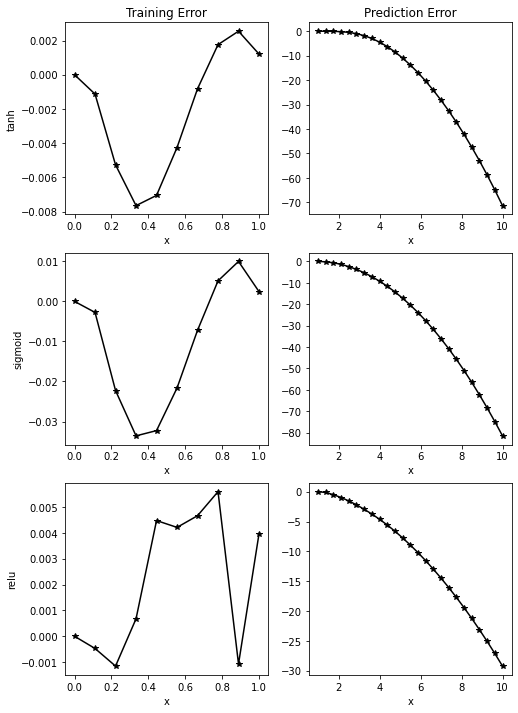

In [10]:
N = 25
ya = analytic_sol(x)
x_new = torch.linspace(1, 10, N, requires_grad=True)
xl_new = x_new.detach().numpy()
ya_new = analytic_sol(x_new.detach().numpy())

_, axes = plt.subplots(figsize=(8,12), nrows=3, ncols=2)

axes[0,0].plot(x, net(x_tens).detach().numpy().flatten() - ya, '-*k')
axes[0,0].set_title('Training Error')
axes[0,0].set_xlabel('x')
axes[0,0].set_ylabel('tanh')

axes[0,1].plot(xl_new, net(x_new).detach().numpy().flatten() - ya_new, '-*k')
axes[0,1].set_title('Prediction Error')
axes[0,1].set_xlabel('x')

axes[1,0].plot(x, nets[0](x_tens).detach().numpy().flatten() - ya, '-*k')
axes[1,0].set_ylabel(activations[0])
axes[1,0].set_xlabel('x')

axes[1,1].plot(xl_new, nets[0](x_new).detach().numpy().flatten() - ya_new, '-*k')
axes[1,1].set_xlabel('x')

axes[2,0].plot(x, nets[1](x_tens).detach().numpy().flatten() - ya, '-*k')
axes[2,0].set_ylabel(activations[1])
axes[2,0].set_xlabel('x')

axes[2,1].plot(xl_new, nets[1](x_new).detach().numpy().flatten() - ya_new, '-*k')
axes[2,1].set_xlabel('x')

plt.savefig('activations.png')
plt.show()

## Add another layer (UNFINISHED)

In [54]:
class TwoLayer(nn.Module):

    def __init__(self, H):
        super(TwoLayer, self).__init__()
        self.H = H
        self.z1 = nn.Linear(1, H)
        self.v1 = nn.Linear(H, 1, bias=False)
        self.z2 = nn.Linear(1, H)
        self.v2 = nn.Linear(H, 1, bias=False)
        self.sigma = nn.ReLU()  # default to ReLU since it worked so well

    def forward(self, x):
        x = x.reshape(-1, 1)
        layer1 = self.v1(self.sigma(self.z1(x)))
        layer2 = self.v2(self.sigma(self.z2(layer1)))
        return torch.add(x * layer2, torch.tensor([1.]))

In [55]:
# Main training function
def train_two_layer(x_tens, nepochs, H, delta):
    net = TwoLayer(H)
    net.zero_grad()
    criterion = nn.MSELoss()
    optimizer = SGD(net.parameters(), lr=0.01)

    for epoc in range(nepochs):
        for i in range(len(x_tens)):
            batch = x_tens[np.random.randint(0, n)]
            optimizer.zero_grad()
            
            output = net(batch)  # forward
            loss = criterion(dtrial(batch, net, delta), forcing(batch, net))
            loss.backward()  # backward
            optimizer.step()  # optimize
    
    return net

In [ ]:
x_tens = torch.linspace(1, n, requires_grad=True)  # reset training mesh
two_layer = train_two_layer(x_tens, nepochs, H, delta)

In [ ]:
y_pred = two_layer(x_tens).detach().numpy()
ya = analytic_sol(x)

_, (ax1, ax2) = plt.subplots(figsize=(12,4), ncols=2)
ax1.plot(x, y_pred, 'k', x, ya, 'r')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.legend(['NN Solution', 'Analytic Solution'])
ax1.set_title('Solution')

ax2.plot(x, y_pred.flatten() - ya, '-*k')
ax2.set_xlabel('x')
ax2.set_ylabel('predicted - analytic')
ax2.set_title('Pointwise error')
plt.savefig('train-2layer.png')
plt.show()